Implementing Recommender System

In [0]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [0]:
import pandas as pd
tb_final = pd.read_csv('/content/drive/My Drive/tb_final.csv')

In [0]:
tb_final.head()

user_id  item_id  category_id behavior_type   timestamp
0        1  3219016      3002561            pv  02/12/2017
1        1  4954999       411153            pv  03/12/2017
2        1   818610       411153            pv  03/12/2017
3        1   568695      1320293            pv  03/12/2017
4        1  2278603      3002561            pv  02/12/2017

In [0]:
tb_final.behavior_type.unique()

array(['pv', 'fav', 'cart', 'buy'], dtype=object)

In [0]:
#Assign weights to each behavior type, according to their importance. It is reasonable to assume that the order of importance would be: buy>cart>fav>pv.
#Merge the preference (p) for an item with the confidence (c) we have for that preference
#Instead of representing an explicit rating, the behavior_strength can represent the confidence  in terms of how strong the user interaction was.

behavior_type_strength = {
   'pv': 1.0,
   'fav': 2.0, 
   'cart': 3.0, 
   'buy': 4.0 
}

tb_final['behavior_strength'] = tb_final['behavior_type'].apply(lambda x: behavior_type_strength[x])

In [0]:
#Group behavior_strength together with user_id and item_id and category_id
grouped_tb = tb_final.groupby(['user_id', 'item_id', 'category_id']).sum().reset_index()


In [0]:
grouped_tb.head()

user_id  item_id  category_id  behavior_strength
0        1   271696       411153                1.0
1        1   568695      1320293                1.0
2        1   818610       411153                1.0
3        1   929177      4801426                1.0
4        1  1323189      3524510                1.0

In [0]:
# merge the preference (p) for an item with the confidence (c) we have for that preference
# convert user id and item id into numeric

grouped_tb['user'] = grouped_tb['user_id'].astype("category").cat.codes
grouped_tb['item'] = grouped_tb['item_id'].astype("category").cat.codes
grouped_tb['category'] = grouped_tb['category_id'].astype("category").cat.codes

In [0]:
grouped_tb.head()

user_id  item_id  category_id  behavior_strength  user   item  category
0        1   271696       411153                1.0     0  10371       380
1        1   568695      1320293                1.0     0  21609      1140
2        1   818610       411153                1.0     0  30955       380
3        1   929177      4801426                1.0     0  35058      4234
4        1  1323189      3524510                1.0     0  49815      3106

In [0]:
len(grouped_tb['item'].unique())

195257

In [0]:
len(grouped_tb['category'].unique())

4538

In [0]:
!pip install implicit

     |████████████████████████████████| 1.1MB 2.8MB/s 
  Created wheel for implicit: filename=implicit-0.4.2-cp36-cp36m-linux_x86_64.whl size=3471558 sha256=b86882450dffe1ca8dadaa3b2e0b8d537e64c9413d861cd602f12f0c01a8ef17
  Stored in directory: /root/.cache/pip/wheels/1b/48/b1/1aebe3acc3afb5589e72d3e7c3ffc3f637dc4721c1a974dff7
Successfully built implicit


In [0]:
import scipy.sparse as sparse
import numpy as np
import implicit

In [0]:
#Create two matrices:
#Matrix 1: model fitting (item-user) 
#Matrix 2: recommendation (user-item)


sparse_item_user = sparse.csr_matrix((grouped_tb['behavior_strength'].astype(float), (grouped_tb['item'], grouped_tb['user'])))
sparse_user_item = sparse.csr_matrix((grouped_tb['behavior_strength'].astype(float), (grouped_tb['user'], grouped_tb['item'])))

#print(sparse_user_item.shape[0])

In [0]:
#Alternating Least Squares Method
model = implicit.als.AlternatingLeastSquares(factors=32, regularization=0.1, iterations=10, use_gpu=True)

In [63]:
#Calculate the confidence for each value in our data
#Alpha value between 15 and 40 is advisable. Ref: https://medium.com/radon-dev/als-implicit-collaborative-filtering-5ed653ba39fe
alpha = 20
data = (sparse_item_user * alpha).astype('double')
model.fit(data)

In [0]:
from sklearn.preprocessing import MinMaxScaler

In [0]:
#Function for recommender 

def recommend(user, sparse_user_item, user_vecs, item_vecs, num_items=10):

    #Interactions scores from the sparse user-item matrix
    user_interactions = sparse_user_item[user,:].toarray()
   

    # We don't want to recommend items the user has interacted with. 
    # Set user interactions for these to be 0 and unknowns to 1.
    
    user_interactions = user_interactions.reshape(-1) + 1

    user_interactions[user_interactions > 1] = 0
    

    #Dot product of user vector and all item vectors
    rec_vector = user_vecs[user,:].dot(item_vecs.T).toarray()
    

    #Scale the recommendation vector between 0 and 1
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0]
    

    # Multiply the recommendation of those item already interacted by zero 
    recommend_vector = user_interactions * rec_vector_scaled


    # Sort the indices of the items by order of recommendation
    item_index = np.argsort(recommend_vector)[::-1][:num_items]
    
    # Store item IDs, category IDs and scores
    items = []
    categories =[]
    scores = []

    for index in item_index:
        items.append(grouped_tb.item.loc[grouped_tb.item == index].iloc[0])
        scores.append(recommend_vector[index])
        categories.append(grouped_tb.category.loc[grouped_tb.item == index].iloc[0])

    recommendations = pd.DataFrame({'Item ID': items, 'Score': scores, 'Category ID': categories})

    return recommendations
    


In [0]:
# Get the trained user and item vectors. Convert to csr_matrix.
user_vecs = sparse.csr_matrix(model.user_factors)
item_vecs = sparse.csr_matrix(model.item_factors)

In [96]:
# Example: Create recommendations for user with id 2124 (most active user)
# View the top 10 scores with their respective Item IDs and Category IDs

user = 2124

recommendations = recommend(user, sparse_user_item, user_vecs, item_vecs)

print(recommendations)

   Item ID     Score  Category ID
0     2289  1.000000         4250
1    57904  0.860529         3416
2    86084  0.710473         2014
3   123740  0.674860         2008
4    77792  0.673336         1658
5    92639  0.622833         3217
6   136467  0.618529         2175
7    71709  0.611444          247
8    59744  0.609827          305
9    67311  0.608410         1753


In [0]:
#There are 9678 users
grouped_tb.user.unique()

array([   0,    1,    2, ..., 9676, 9677, 9678])

In [0]:
#Recommender for all users
i = 0

for i in range(len(grouped_tb.user.unique())):
  if(i%10==0): #Did not loop through every single user as this will crash the system. To remove the 'if' condition to see each user's top 10 recommended items.
    print("User:", i, "\n")
    print(recommend(i, sparse_user_item, user_vecs, item_vecs))
    print("\n\n")
    i+=1

User: 0 

   Item ID     Score  Category ID
0   106502  1.000000          862
1    59704  0.861519         4234
2    24320  0.861165         2056
3    43880  0.859611         2768
4   177517  0.849011          380
5   175668  0.801070         4191
6    52820  0.780437          862
7    67311  0.747667         1753
8    57904  0.746093         3416
9   116744  0.743062         4320



User: 10 

   Item ID     Score  Category ID
0    86084  0.829702         2014
1    59744  0.772407          305
2   159299  0.732223         4191
3     8946  0.694227         3654
4    57904  0.679978         3416
5    77792  0.647131         1658
6    99702  0.644682          826
7    81653  0.636520         3370
8   178973  0.631228         4234
9   123740  0.619358         2008



User: 20 

   Item ID     Score  Category ID
0   134616  0.855479         4234
1   132972  0.819328         2056
2   145605  0.818647         3170
3   189915  0.774904          357
4    13108  0.770305          947
5    57904

Evaluate Recommender System

In [0]:
#Ref: https://jessesw.com/Rec-System/
import random

def make_train(sparse_mtx, pct_test = 0.2):

#sparse_mtx
#he original matrix from which you want to generate a train/test set. Test is just a complete copy of the original set. This is in the form of a sparse csr_matrix. 

#pct_test:
#The percentage of user-item interactions where an interaction took place that you want to mask in the training set for later comparison to the test set, which contains all of the original ratings. 

    test_set = sparse_mtx.copy() # Make a copy of the original set to be the test set. 
    test_set[test_set != 0] = 1 # Store the test set as a binary preference matrix
    
    training_set = sparse_mtx.copy() # Make a copy of the original data we can alter as our training set. 
    
    nonzero_indices = training_set.nonzero() # Find the indices in the data where an interaction exists
    nonzero_pairs = list(zip(nonzero_indices[0], nonzero_indices[1])) # Zip item, user into list

    
    random.seed(42) # Set the random seed to 42 for reproducibility
    
    num_samples = int(np.ceil(pct_test*len(nonzero_pairs))) # Round the number of samples needed to the nearest integer
    samples = random.sample(nonzero_pairs, num_samples) # Sample a random number of item-user pairs without replacement

    item_indices = [index[0] for index in samples] # Get the item row indices

    user_indices = [index[1] for index in samples] # Get the user column indices

    
    training_set[item_indices, user_indices] = 0 # Assign all of the randomly chosen user-item pairs to zero
    training_set.eliminate_zeros() # Get rid of zeros in sparse array storage after update to save space
    
    return training_set, test_set, list(set(user_indices))

In [0]:
item_train, item_test, item_users_altered = make_train(sparse_item_user, pct_test = 0.2)

In [0]:
from sklearn import metrics

In [0]:
def auc_score(predictions, test):
    fpr, tpr, thresholds = metrics.roc_curve(test, predictions)
    return metrics.auc(fpr, tpr)

In [0]:
def calc_mean_auc(training_set, altered_users, predictions, test_set):
    store_auc = [] # An empty list to store the AUC for each user that had an item removed from the training set
    popularity_auc = [] # To store popular AUC scores
    pop_items = np.array(test_set.sum(axis = 1)).reshape(-1) # Get sum of item iteractions to find most popular
    item_vecs = predictions[1]

    count = 0

    for user in altered_users: # Iterate through each user that had an item altered
        training_column = training_set[:,user].toarray().reshape(-1) # Get the training set column
        zero_inds = np.where(training_column == 0) # Find where the interaction had not yet occurred
        
        # Get the predicted values based on our user/item vectors
        user_vec = predictions[0][user,:]
        pred = user_vec.dot(item_vecs).toarray()[0,zero_inds].reshape(-1)
        
        # Get only the items that were originally zero
        # Select all ratings from the MF prediction for this user that originally had no iteraction
        actual = test_set[:,user].toarray()[zero_inds,0].reshape(-1)
        
        # Select the binarized yes/no interaction pairs from the original full data
        # that align with the same pairs in training 
        pop = pop_items[zero_inds] # Get the item popularity for our chosen items
        
        store_auc.append(auc_score(pred, actual)) # Calculate AUC for the given user and store
        
        popularity_auc.append(auc_score(pop, actual)) # Calculate AUC using most popular and store
        
        
        if (count%10==0): #prints every 10th user as system will crash if output AUC of all users.
          print("User:", count, store_auc[count])
        count+=1
    # End users iteration

    return float('%.3f'%np.mean(store_auc)), float('%.3f'%np.mean(popularity_auc))

In [73]:
calc_mean_auc(item_train, item_users_altered,
              [user_vecs, item_vecs.T], item_test)

User: 0 0.7170802496009288
User: 10 0.8560681729319586
User: 20 0.6078095950257878
User: 30 0.8822848538547818
User: 40 0.953707023726591
User: 50 0.9967884182851675
User: 60 0.9206716903421461
User: 70 0.9877894937107149
User: 80 0.9972700965453661
User: 90 0.9271547176382615
User: 100 0.9973656963927832
User: 110 0.9946172585834886
User: 120 0.9434885085635804
User: 130 0.9973359324841986
User: 140 0.821641852198987
User: 150 0.6972190779600597
User: 160 0.997500435374986
User: 170 0.855197540159357
User: 180 0.9955410747439729
User: 190 0.8010247636999399
User: 200 0.9853125288145318
User: 210 0.9714279129085294
User: 220 0.9944067944206251
User: 230 0.9631835062107824
User: 240 0.7598162243005973
User: 250 0.8931548853797994
User: 260 0.9086149842739911
User: 270 0.996273490612862
User: 280 0.9930812745344118
User: 290 0.7146398426616406
User: 300 0.983379039577463
User: 310 0.5997992338106651
User: 320 0.9983650719653753
User: 330 0.8999311919165015
User: 340 0.9967339369780831
Us

(0.911, 0.647)

As a benchmark, I calculated the mean AUC for most popular items, to compare it with the recommender for top 10 items. My recommender system performed well (mean AUC score of 0.911) vis-a-vis the benchmark recommender (mean AUC score of 0.647).

In [0]:
import matplotlib.pyplot as plt

In [0]:
def plot_roc(user, training_set, altered_users, predictions, test_set):
    item_vecs = predictions[1]
    
    #Example: User 2
    #user = 2
    if user in altered_users: 
      training_column = training_set[:,user].toarray().reshape(-1) 
      zero_inds = np.where(training_column == 0) 
      pop_items = np.array(test_set.sum(axis = 1)).reshape(-1)   
    
      user_vec = predictions[0][user,:]
      pred = user_vec.dot(item_vecs).toarray()[0,zero_inds].reshape(-1)
      actual = test_set[:,user].toarray()[zero_inds,0].reshape(-1)
      pop = pop_items[zero_inds]

    # Define true positive rate and false positive rate.
      fpr, tpr, thresholds = metrics.roc_curve(actual, pred)
      fpr_pop, tpr_pop, thresholds_pop = metrics.roc_curve(actual, pop)

    # Plot ROC.
      plt.plot(fpr, tpr, label='ROC Curve')

    # Plot baseline. 
      #plt.plot(np.linspace(0, 1, 200),  np.linspace(0, 1, 200), label='baseline', linestyle='--')
      plt.plot (fpr_pop, tpr_pop, label='Baseline', linestyle = '--')

    # Label axes.
      plt.title('Receiver Operating Characteristic Curve', fontsize=18)
      plt.ylabel('Sensitivity', fontsize=14)
      plt.xlabel('1 - Specificity', fontsize=14)

    # Create legend.
      plt.legend(fontsize=14);

    return plt.show()

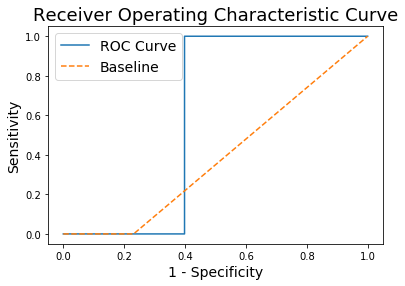

In [93]:
#plot ROC curve for top 3 most active users
plot_roc(2124, item_train, item_users_altered, [user_vecs, item_vecs.T], item_test)

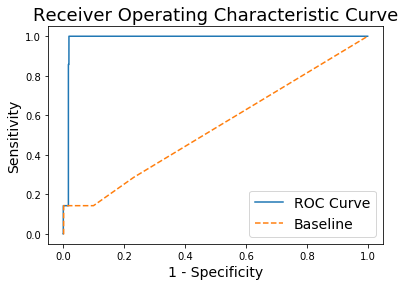

In [94]:
plot_roc(6536, item_train, item_users_altered, [user_vecs, item_vecs.T], item_test)

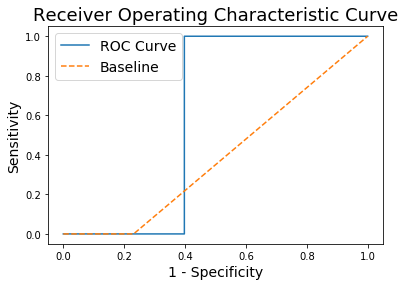

In [95]:
plot_roc(6022, item_train, item_users_altered, [user_vecs, item_vecs.T], item_test)

Graphical visualization of the ROC. From the graph above, the ROC curve is mostly above the baseline, which indicates that my positive and negative populations are more separated and hence my model is good.